In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import langdetect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn import decomposition

## First, install Vader Lexicon for sentiment analysis

In [17]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alechuffman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
reviews = pd.read_csv("airbnb_reviews.csv")
reviews = reviews.dropna()

## Getting an overview of the data

In [13]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."


## Vader Lexicon allows us to get positive, negative, neutral polarity scores of reviews

In [22]:
SID = SentimentIntensityAnalyzer()

reviews['polarity_value']="Default"
reviews['neg']=0.0
reviews['pos']=0.0
reviews['neu']=0.0
reviews['compound']=0.0
for index,row in reviews.iterrows():
    ss = SID.polarity_scores(row['comments'])
    reviews.at[index,'polarity_value'] = ss
    reviews.at[index,'neg'] = ss['neg']
    reviews.at[index,'pos'] = ss['pos']
    reviews.at[index,'neu']= ss['neu']
    reviews.at[index,'compound'] = ss['compound']

In [23]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.000,0.538,0.462,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,"{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'comp...",0.000,0.391,0.609,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...","{'neg': 0.043, 'neu': 0.772, 'pos': 0.185, 'co...",0.043,0.185,0.772,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,"{'neg': 0.035, 'neu': 0.765, 'pos': 0.2, 'comp...",0.035,0.200,0.765,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,"{'neg': 0.0, 'neu': 0.655, 'pos': 0.345, 'comp...",0.000,0.345,0.655,0.9783
...,...,...,...,...,...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...,"{'neg': 0.013, 'neu': 0.852, 'pos': 0.135, 'co...",0.013,0.135,0.852,0.9498
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.000,0.244,0.756,0.8658
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si...","{'neg': 0.098, 'neu': 0.722, 'pos': 0.18, 'com...",0.098,0.180,0.722,0.7468


## We notice there are some reviews which are not in english. We can get rid of those using language detection

In [25]:
def detect_lang(comment_text):
    comment_text=str(comment_text)
    try:
        return detect(comment_text)
    except:
        return "None"

In [26]:
for index,row in reviews.iterrows():
    lang=detect_lang(row['comments'])
    reviews.at[index,'language'] = lang

In [27]:
reviews = reviews[reviews.language=='en']

## Now let's visualize the polarities - First, we'll bin them

In [45]:
polar_df = reviews[['pos']]
polar_df = polar_df.groupby(pd.cut(polar_df["pos"], np.arange(0, 1.0, 0.1))).count()
polar_df = polar_df.rename(columns={'pos':'number_comments'})
polar_df = polar_df.reset_index()
polar_df = polar_df.rename(columns={'pos':'range_i'})
for i,r in polar_df.iterrows():
    polar_df.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polar_df.at[i,'Sentiment'] = 'positive'
del polar_df['range_i']
polar_df.head()

,number_comments,RANGE,Sentiment
0,1644,0.0,positive
1,14099,0.1,positive
2,29158,0.2,positive
3,22314,0.3,positive
4,9890,0.4,positive


In [46]:
polar_neg = reviews[['neg']]
polar_neg = polar_neg.groupby(pd.cut(polar_neg["neg"], np.arange(0, 1.0, 0.1))).count()
polar_neg = polar_neg.rename(columns={'neg':'number_comments'})
polar_neg = polar_neg.reset_index()
polar_neg = polar_neg.rename(columns={'neg':'range_i'})
for i,r in polar_neg.iterrows():
    polar_neg.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polar_neg.at[i,'Sentiment'] = 'negative'
del polar_neg['range_i']

for i,r in polar_neg.iterrows():
    polar_df = polar_df.append(pd.Series([r[0],r[1],r[2]],index=['number_comments','RANGE','Sentiment']),ignore_index=True)
    
polar_neg.head()

,number_comments,RANGE,Sentiment
0,24930,0.0,negative
1,1159,0.1,negative
2,84,0.2,negative
3,21,0.3,negative
4,3,0.4,negative


In [47]:
polar_neu = reviews[['neu']]
polar_neu = polar_neu.groupby(pd.cut(polar_neu["neu"], np.arange(0, 1.0, 0.1))).count()
polar_neu = polar_neu.rename(columns={'neu':'number_comments'})
polar_neu = polar_neu.reset_index()
polar_neu = polar_neu.rename(columns={'neu':'range_i'})
for i,r in polar_neu.iterrows():
    polar_neu.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polar_neu.at[i,'Sentiment'] = 'neutral' 
del polar_neu['range_i']

for i,r in polar_neu.iterrows():
    polar_df = polar_df.append(pd.Series([r[0],r[1],r[2]],index=['number_comments','RANGE','Sentiment']),ignore_index=True)
    
polar_neu.head()

,number_comments,RANGE,Sentiment
0,8,0.0,neutral
1,154,0.1,neutral
2,568,0.2,neutral
3,1346,0.3,neutral
4,3860,0.4,neutral


<Figure size 720x720 with 0 Axes>

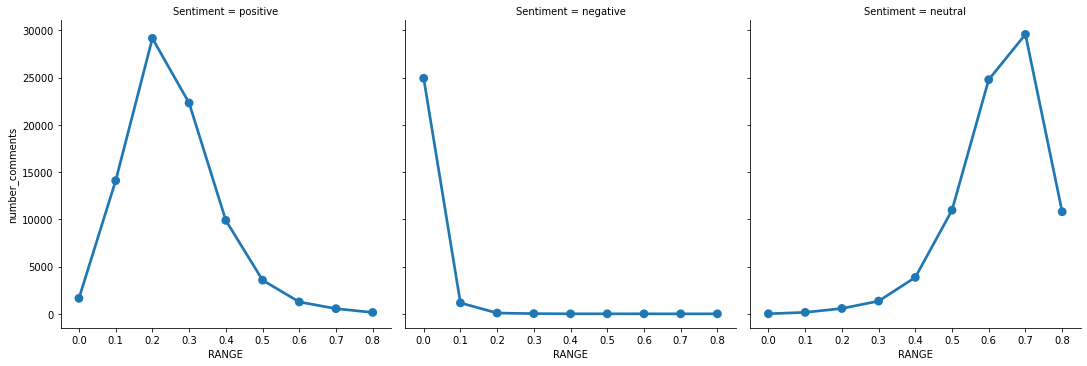

In [53]:
plt.figure(figsize=(10,10))
sns.factorplot(data=polar_df, x="RANGE", y="number_comments",col="Sentiment") 

## Now, let's analyze topics with non-negative matrix factorization

In [55]:
def clean_text(string_in):
    string_in = re.sub("[^a-zA-Z]", " ", str(string_in))  # non-letters to spaces
    string_in = string_in.lower()  
    
    return string_in.strip()

reviews["comments_cleaned"] = reviews.comments.apply(clean_text)

<ipython-input-55-861fe9ac49ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["comments_cleaned"] = reviews.comments.apply(clean_text)


In [59]:
preprocessed = [" ".join(RegexpTokenizer(r'\w+').tokenize(reviews.comments_cleaned[idx])) 
                for idx in reviews.index]  # Tokenizing

### In order to do NMF, the TFIDF matrix must be calculated. We can also filter out stop words using scikit-learn. To add additional stopwords, I can add them to the variable custom_stop_words

In [61]:
custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 83782 x 28749


## Non-negative matrix factorization factors a document word matrix with TFIDF values (V) into two matrices which are referred to as W and H. W represents the document topic matrix while H represents the top words of the topic
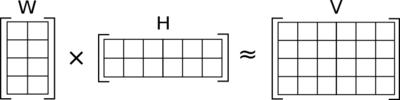

5 topics will be generated

In [63]:
nmf = decomposition.NMF(init = 'nndsvd', n_components = 5, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W matrix of size %s and H matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W matrix of size (83782, 5) and H matrix of size (5, 28749)
Topic #0:
stay place seattle home definitely wonderful recommend perfect time staying

Topic #1:
canceled automated posting reservation arrival days host day late prior

Topic #2:
great location place host stay clean experience awesome thanks easy

Topic #3:
apartment easy restaurants walking downtown distance walk check close seattle

Topic #4:
nice house room really clean good comfortable quiet neighborhood bed

